In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
ds_2_path = "/tanlikesmath/diabetic-retinopathy-resized/versions/7/"
labels_df = pd.read_csv(f"{os.getcwd()}{ds_2_path}trainLabels_cropped.csv")
labels_df = labels_df[["image","level"]]
min_size = labels_df["level"].value_counts().min()

C:\Users\thaim\anaconda3\envs\tf210\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
def load_paths(df,folder):
    paths = []
    for root,_,files in os.walk(f"{os.getcwd()}{folder}"):
        for fname in files :
            if fname.lower().endswith(('.png','jpg','jpeg','bmp','gif')):
                full_path = os.path.join(root,fname)
                bname = os.path.splitext(fname)[0]
                paths.append(
                    {
                        "path" : full_path,
                        df.columns[0] : bname
                    }
                )
    return pd.DataFrame(paths).merge(df,on=df.columns[0])
labels_df = load_paths(labels_df,f"{ds_2_path}resized_train_cropped")

In [4]:
labels_df

,path,image,level
0,C:\Users\thaim\Documents\Machine learning/tanl...,10003_left,0
1,C:\Users\thaim\Documents\Machine learning/tanl...,10003_right,0
2,C:\Users\thaim\Documents\Machine learning/tanl...,10007_left,0
3,C:\Users\thaim\Documents\Machine learning/tanl...,10007_right,0
4,C:\Users\thaim\Documents\Machine learning/tanl...,10009_left,0
...,...,...,...
35103,C:\Users\thaim\Documents\Machine learning/tanl...,9998_right,0
35104,C:\Users\thaim\Documents\Machine learning/tanl...,9999_left,0
35105,C:\Users\thaim\Documents\Machine learning/tanl...,9999_right,0
35106,C:\Users\thaim\Documents\Machine learning/tanl...,99_left,3


In [5]:
#extract balanced dataset
balanced = (
    labels_df
    .groupby("level",group_keys=False)
    .apply(lambda b : b.sample(n=min_size,random_state=42))
    .reset_index(drop=True)
)

C:\Users\thaim\AppData\Local\Temp\ipykernel_48664\2325597260.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda b : b.sample(n=min_size,random_state=42))


In [6]:
balanced["level"].value_counts()

level
0    708
1    708
2    708
3    708
4    708
Name: count, dtype: int64

In [7]:
len(balanced)

3540

In [9]:
from PIL import Image
def load_img(path,size=None):
    img = Image.open(path).convert("RGB")
    if size : 
        img = img.resize(size)
    return np.array(img)
ds_balanced = balanced
ds_balanced["path"] = balanced["path"].apply(lambda p : load_img(p,size=(224,224)))
ds_balanced.head()

,path,image,level
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",13875_left,0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",20322_left,0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",41290_right,0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3333_right,0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",35854_left,0


In [12]:
type(ds_balanced["path"].iloc[0]),ds_balanced["path"].iloc[0].shape

(numpy.ndarray, (224, 224, 3))

In [13]:
#save balanced dataset to folder "balanced_ds"
def save_by_label(X, Y, out_dir='dataset_by_label', prefix='img'):
    """
    X: np.ndarray, shape (N,H,W) or (N,H,W,3), dtype uint8 [0–255] or float [0–1]
    Y: array-like of length N, labels (str or int)
    out_dir: root folder to create class subfolders in
    prefix: filename prefix, images will be named prefix_i.png
    """
    os.makedirs(out_dir, exist_ok=True)
    N = len(Y)
    
    for i, (img, label) in enumerate(zip(X, Y)):
        # 1) Prepare the label folder
        label_str = str(label)
        label_dir = os.path.join(out_dir, label_str)
        os.makedirs(label_dir, exist_ok=True)

        # 2) Convert image to uint8 BGR if needed
        #    handle float [0,1] → uint8 [0,255]
        if img.dtype in (np.float32, np.float64):
            img_uint8 = (img * 255).round().astype(np.uint8)
        else:
            img_uint8 = img

        #    if it’s RGB, convert to BGR for cv2
        if img_uint8.ndim == 3 and img_uint8.shape[2] == 3:
            to_save = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        else:
            # grayscale or single‐channel
            to_save = img_uint8

        # 3) Choose a filename
        fname = f"{prefix}_{i:05d}.png"
        save_path = os.path.join(label_dir, fname)

        # 4) Write it out
        cv2.imwrite(save_path, to_save)

    print(f"Saved {N} images into {out_dir!r} with {len(set(Y))} class folders.")

In [18]:
N = len(ds_balanced)
imgs = np.stack(ds_balanced["data"].values,axis=0)
labels = ds_balanced["level"].values

In [15]:
ds_balanced.rename(columns={"path":"data"},inplace = True)
ds_balanced.columns

Index(['data', 'image', 'level'], dtype='object')

In [20]:
save_by_label(X=imgs,Y=labels,out_dir="balanced_ds")

Saved 3540 images into 'balanced_ds' with 5 class folders.


In [23]:
random_sample = (
    labels_df
    .groupby("level",group_keys=False)
    .apply(lambda b:b.sample(n = int(min_size*0.5),random_state = 99))
    .reset_index(drop=True)
)
random_sample.head()

C:\Users\thaim\AppData\Local\Temp\ipykernel_48664\29016535.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda b:b.sample(n = int(min_size*0.5),random_state = 99))


,path,image,level
0,C:\Users\thaim\Documents\Machine learning/tanl...,2350_left,0
1,C:\Users\thaim\Documents\Machine learning/tanl...,25072_right,0
2,C:\Users\thaim\Documents\Machine learning/tanl...,27014_left,0
3,C:\Users\thaim\Documents\Machine learning/tanl...,15351_left,0
4,C:\Users\thaim\Documents\Machine learning/tanl...,5096_right,0


In [40]:
ds_random_s = random_sample
ds_random_s["path"] = random_sample["path"].apply(lambda p:load_img(p,size=(224,224)))
ds_random_s.rename(columns={"path":"data"},inplace = True)
ds_random_s.head()

,data,image,level
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2350_left,0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",25072_right,0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",27014_left,0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",15351_left,0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5096_right,0


In [41]:
X_s = np.stack(ds_random_s["data"].values,axis=0)
Y_s = ds_random_s["level"].values

In [44]:
save_by_label(X=X_s,Y=Y_s,out_dir="sample_ds")

Saved 1770 images into 'sample_ds' with 5 class folders.


In [42]:
len(ds_random_s)

1770

In [38]:
random_sample.rename(columns={"data":"path"},inplace = True)

In [49]:
def preprocess_fundus(img, size=None):
    """
    img: H×W×3 uint8 array (0–255)
    size: (new_W, new_H) tuple, or None to skip resizing
    Returns: single‐channel float32 [0,1] CLAHE’ed green channel
    """
    # 1) resize with OpenCV (not np.resize)
    if size is not None:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)

    # 2) extract green channel
    green = img[:, :, 1]  # still uint8

    # 3) apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green_enhanced = clahe.apply(green)  # uint8 [0,255]

    # 4) normalize to [0,1] float32
    preprocessed = green_enhanced.astype(np.float32) / 255.0

    return preprocessed  # shape (H, W)


In [50]:
processed_bds = ds_balanced
processed_bds["data"] = processed_bds["data"].apply(lambda i:preprocess_fundus(i))
p_xtrain = np.stack(processed_bds["data"].values,axis=0)
ytrain = labels

In [68]:
def plot_transformation(original_img,transformed_img,size=(10,5),id_img=None):
    fig,axes = plt.subplots(1,2,figsize=size)
    fig.patch.set_facecolor("black")
    axes[0].imshow(original_img)
    axes[0].set_title("Raw",color="white")
    axes[0].axis("off")
    axes[1].imshow(transformed_img,cmap="gray" if transformed_img.ndim==2 else None)
    axes[1].set_title("Preprocessed",color="white")
    axes[1].axis("off")
    if id_img :
        fname = os.path.join("preprocessed_previews",f"sample_{id_img:03d}.png")
    else :
        fname = os.path.join("preprocessed_previews",f"sample.png")
    fig.savefig(fname,dpi=300,bbox_inches='tight')

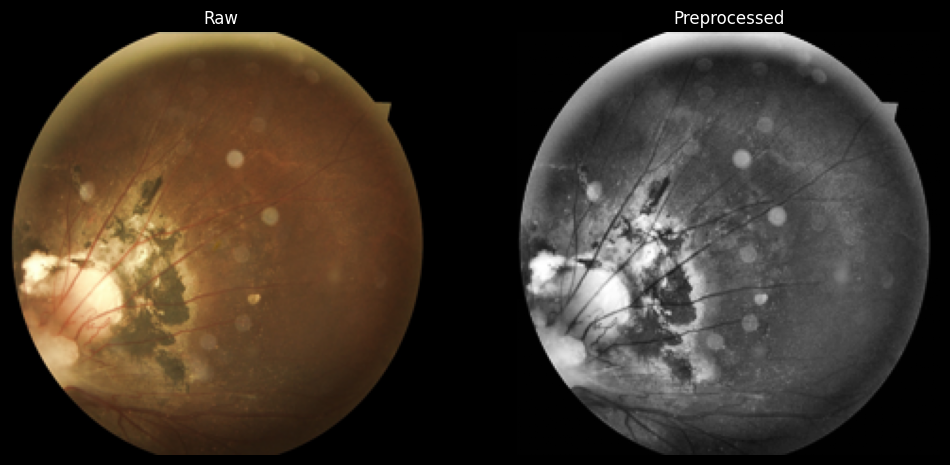

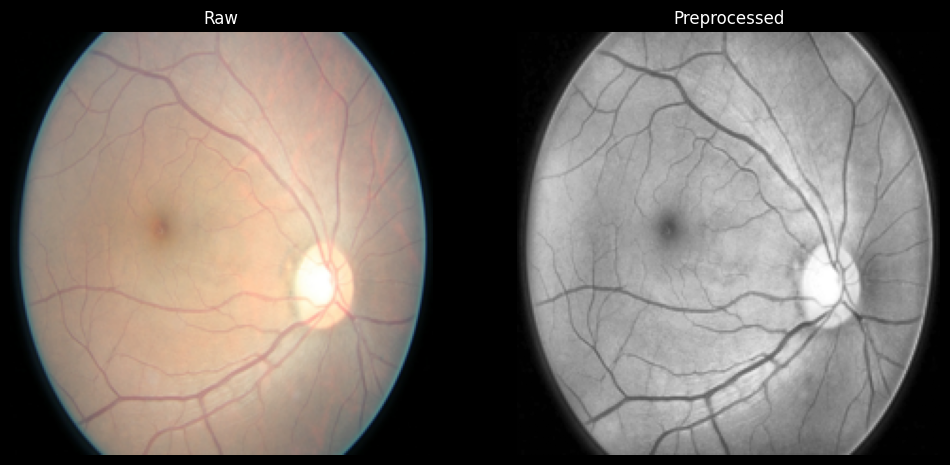

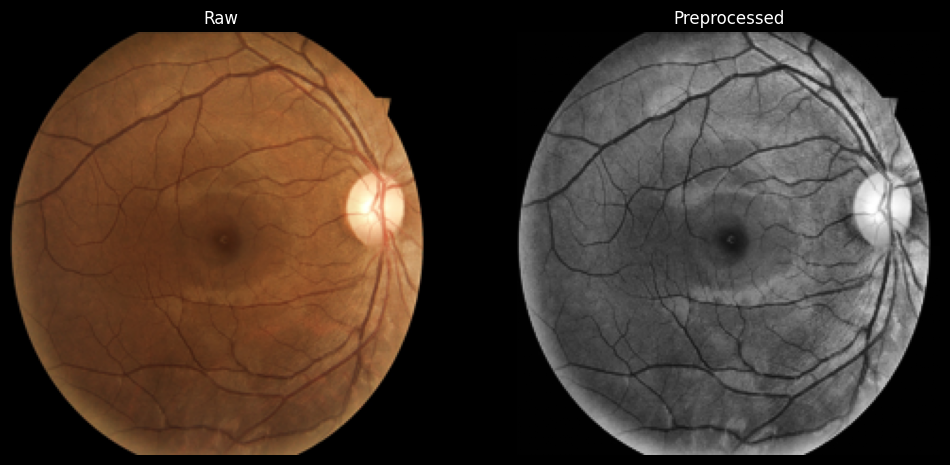

In [ ]:
for i in range(10):
    plot_transformation(imgs[i],p_xtrain[i],size=(12,6),id_img=i)

In [72]:
save_by_label(X=p_xtrain,Y=labels,out_dir="/dataset/preprocessed_train")

Saved 3540 images into '/dataset/preprocessed_train' with 5 class folders.


In [74]:
p_val = ds_random_s.copy(deep=True)
p_val.head()

,data,image,level
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2350_left,0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",25072_right,0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",27014_left,0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",15351_left,0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5096_right,0


In [75]:
p_val["data"] = p_val["data"].apply(lambda i : preprocess_fundus(i))

In [76]:
p_xval = np.stack(p_val["data"].values,axis=0)
save_by_label(X=p_xval,Y=Y_s,out_dir=f"{os.getcwd()}dataset/preprocessed_val")

Saved 1770 images into 'C:\\Users\\thaim\\Documents\\Machine learningdataset/preprocessed_val' with 5 class folders.
